In [310]:
import pandas as pd
import numpy as np
import tensorflow as tf
from data_loader import load_veterans_ds, prepare_veterans_ds
from sklearn.preprocessing import StandardScaler
from utility import InputFunction, CindexMetric, CoxPHLoss, _make_riskset, _TFColor
import matplotlib.pyplot as plt

TFColor = _TFColor()

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# Load data
X_train, X_valid, X_test, y_train, y_valid, y_test = load_veterans_ds()
t_train, t_valid, t_test, e_train, e_valid, e_test  = prepare_veterans_ds(y_train, y_valid, y_test)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


In [311]:
# Compute risk set for 5 samples
n_samples = 5
train_event_set = tf.expand_dims(e_train[:n_samples].astype(np.int32), axis=1)
train_risks_set = tf.convert_to_tensor(_make_riskset(t_train[:n_samples]))
pred_ = tf.convert_to_tensor(np.linspace(0.1, 0.9, n_samples).reshape(n_samples,1).astype(np.float32)) # random prediction

# Run loss function
loss_fn = CoxPHLoss()
loss_fn(y_true=[train_event_set, train_risks_set], y_pred=pred_)

<tf.Tensor: shape=(), dtype=float32, numpy=1.047399>

In [312]:
pred_

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.1],
       [0.3],
       [0.5],
       [0.7],
       [0.9]], dtype=float32)>

In [313]:
X_train = np.array(X_train)

y_obs = tf.convert_to_tensor(t_train[e_train])
y_cens = tf.convert_to_tensor(t_train[~e_train])

x_obs = tf.convert_to_tensor(X_train[e_train][:,0]) # 1 feature
x_cens = tf.convert_to_tensor(X_train[~e_train][:,0]) # 1 feature

In [314]:
obs_model = tfd.JointDistributionSequential(
  [
    tfd.Normal(3, 3), #alpha
    tfd.Normal(0, 3), #beta
    lambda beta, alpha:
      tfd.Independent(tfd.Sample(
        tfd.Exponential(rate =
            1/tf.math.exp(tf.cast(x_obs[tf.newaxis,...], beta.dtype)*beta[...,tf.newaxis]+\
                        alpha[...,tf.newaxis])
        )), reinterpreted_batch_ndims = 1)
  ]
)

def log_prob(x_obs, x_cens, y_obs, y_cens, alpha, beta):
    lp = obs_model.log_prob([alpha, beta, tf.cast(y_obs, alpha.dtype)[tf.newaxis,...]])
    potential = exponential_lccdf(x_cens, y_cens, alpha, beta)
    return lp + potential

def exponential_lccdf(x_cens, y_cens, alpha, beta):
    return tf.reduce_sum(
        -tf.cast(y_cens[tf.newaxis,...],alpha.dtype) / tf.exp(tf.cast(x_cens[tf.newaxis,...],
                                                                      beta.dtype) * beta[...,tf.newaxis] + alpha[...,tf.newaxis]),
        axis=-1
    )

In [315]:
from utility import sample_hmc

n_chains = 1
number_of_steps = 10000
number_burnin_steps = 1000

initial_coeffs = obs_model.sample(n_chains)
unnormalized_post_log_prob = lambda *args: log_prob(x_obs, x_cens, y_obs, y_cens, *args)
alphas, betas = sample_hmc(unnormalized_post_log_prob, [tf.zeros_like(initial_coeffs[0]),
                                                        tf.zeros_like(initial_coeffs[1])],
                           n_steps=number_of_steps, n_burnin_steps=number_burnin_steps)

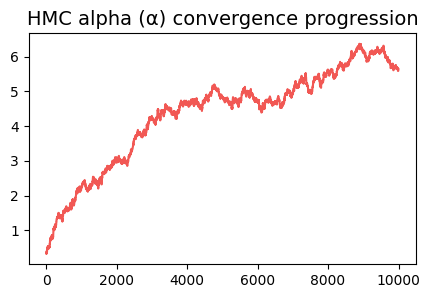

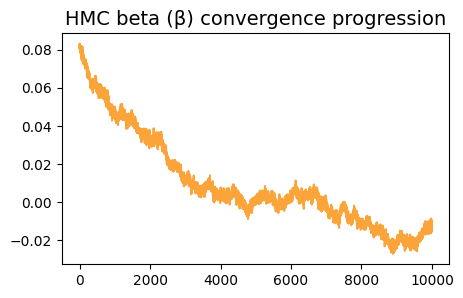

In [316]:
# plotting the Posterior Samples
plt.figure(figsize=(5,3))
plt.plot(np.arange(number_of_steps), alphas, color=TFColor[0])
plt.title('HMC alpha (α) convergence progression', fontsize=14)

plt.figure(figsize=(5,3))
plt.plot(np.arange(number_of_steps), betas, color=TFColor[1])
plt.title('HMC beta (β) convergence progression', fontsize=14)
plt.show()

Text(0.5, 1.0, 'KDE plot for beta (β) samples')

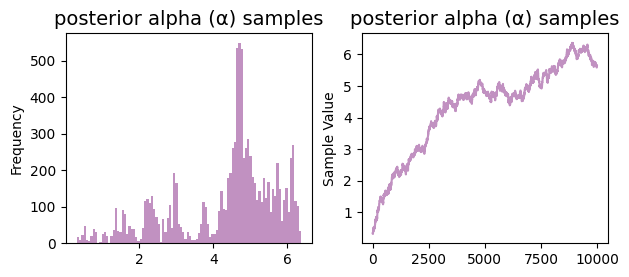

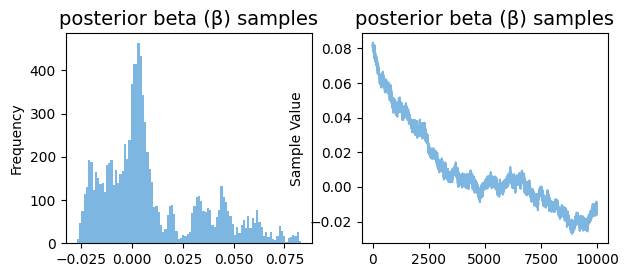

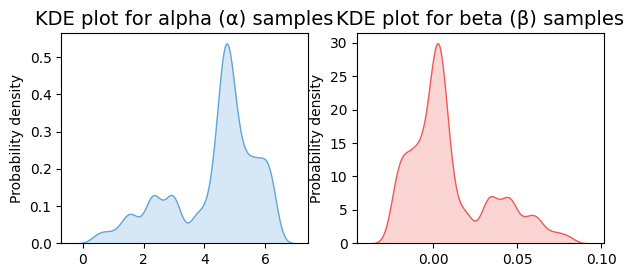

In [317]:
# plotting the Posterior Samples
import seaborn as sns

#alpha (α)
#beta (β)

plt.figure(figsize=(7,6))
plt.subplot(2, 2, 1)
plt.hist(alphas[:,0], bins=100, color=TFColor[6], alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior alpha (α) samples', fontsize=14)

plt.subplot(2, 2, 2)
plt.plot(np.arange(number_of_steps), alphas[:,0], color=TFColor[6], alpha=0.8)
plt.ylabel('Sample Value')
plt.title('posterior alpha (α) samples', fontsize=14)

plt.figure(figsize=(7,6))
plt.subplot(2, 2, 1)
plt.hist(betas[:,0], bins=100, color=TFColor[3], alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior beta (β) samples', fontsize=14)

plt.subplot(2, 2, 2)
plt.plot(np.arange(number_of_steps), betas[:,0], color=TFColor[3], alpha=0.8)
plt.ylabel('Sample Value')
plt.title('posterior beta (β) samples', fontsize=14)

#KDE Plots
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.figure(figsize=(7,6))
plt.subplot(2, 2, 1)
ax2 = sns.kdeplot(alphas[:,0], fill=True, color=TFColor[3], bw_method='scott')
plt.ylabel('Probability density')
plt.title('KDE plot for alpha (α) samples', fontsize=14)

plt.subplot(2, 2, 2)
ax1 = sns.kdeplot(betas[:,0], fill=True, color=TFColor[0], bw_method='scott')
plt.ylabel('Probability density')
plt.title('KDE plot for beta (β) samples', fontsize=14)

Text(0.5, 0, '$\\lambda$')

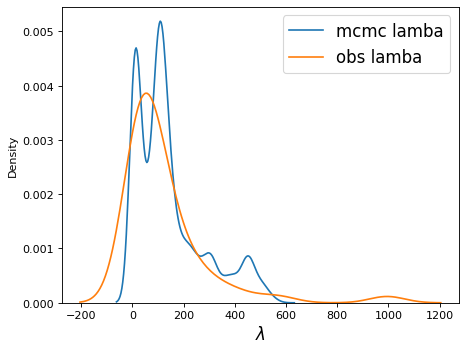

In [387]:
lambda_ = np.exp(alphas + betas)

plt.figure(dpi=80)
sns.kdeplot(lambda_, label='mcmc lamba')
sns.kdeplot(y_obs, label='obs lamba')
plt.legend(fontsize=15)
plt.xlabel("$\lambda$",size=15)

In [377]:
y_obs

<tf.Tensor: shape=(100,), dtype=float64, numpy=
array([ 53.,  42., 228., 162.,  61.,  36.,  18.,  24., 242.,  10.,  18.,
       340., 103.,  25.,  30.,  29.,  54., 378., 200., 126.,   3.,  24.,
       216.,  82.,   1., 231.,  51., 186.,  52.,  31., 100.,  99.,  51.,
       140.,   8., 111.,  87.,   7.,  20., 411.,  21.,  80.,  63., 118.,
         4., 122.,  10.,  95.,  43., 201.,  72.,  52.,  56., 162., 111.,
       287.,  59., 991., 139.,   7., 553.,  90.,  45.,  20.,  84.,  11.,
        99.,  13.,  21., 132.,   7.,   8., 467., 143.,  49.,  33., 999.,
        25., 133., 587.,  16.,  51., 357., 164.,  92.,  15.,  27.,  25.,
       105., 278., 144.,  19.,  15., 112., 283.,  18.,  95., 250.,  48.,
        35.])>

In [318]:
alphas = alphas.numpy().flatten()
betas = betas.numpy().flatten()

In [332]:
predict_func = lambda data: alphas + betas * data
x_train_data = X_train[:,0]

y_preds = np.zeros((len(x_train_data)))
for i, signal in enumerate(x_train_data):
    y_preds[i] = predict_func(signal).mean()

In [320]:
random_guess = tf.convert_to_tensor(np.random.uniform(0, 10, size=(len(y_preds), 1)).astype(np.float32))

In [337]:
train_event_set = tf.expand_dims(e_train.astype(np.int32), axis=1)
train_risks_set = tf.convert_to_tensor(_make_riskset(t_train))
y_pred = tf.convert_to_tensor(y_preds.reshape(len(y_preds), 1).astype(np.float32))

In [339]:
mcmc_train_loss = loss_fn(y_true=[train_event_set, train_risks_set], y_pred=y_pred)
random_guess_loss = loss_fn(y_true=[train_event_set, train_risks_set], y_pred=random_guess)
print(f"MCMC loss {mcmc_train_loss}, random: {random_guess_loss}")

MCMC loss 3.4211440086364746, random: 5.77722692489624
